/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:727: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(spir_rot), cmap='jet', vmin = -12.5, vmax = -8., origin='lower')
/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:727: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(spir_rot), cmap='jet', vmin = -12.5, vmax = -8., origin='lower')
/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:746: RuntimeWarning: invalid value encountered in add
  plt.imshow(-m1crot +m1krot, cmap='seismic', vmin = -0.8, vmax = 0.8, origin='lower')


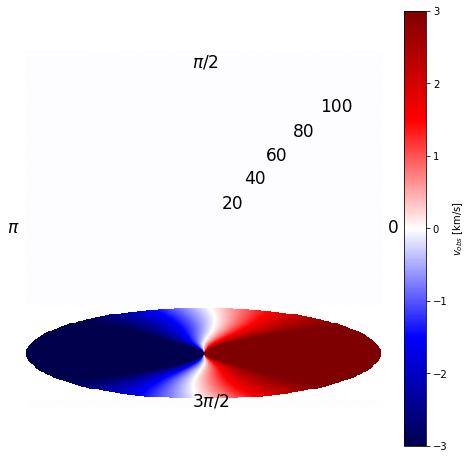

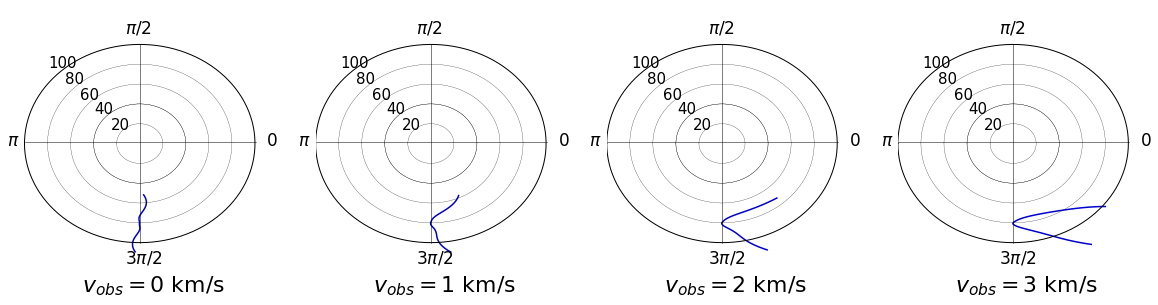

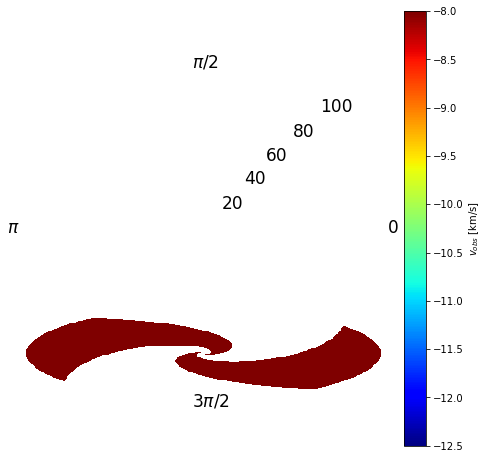

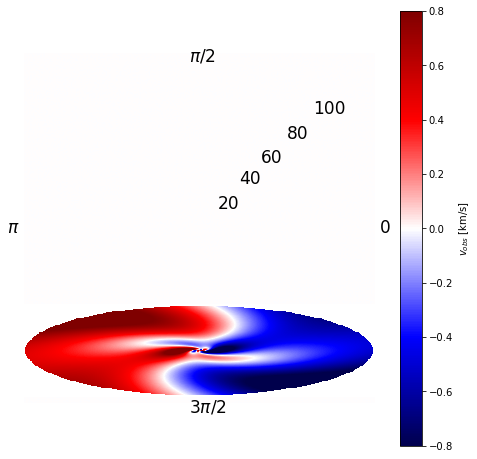

In [1]:
import giggle_functions as giggle
import numpy as np 
import matplotlib.pyplot as plt


import math
import matplotlib.image as mpimg
from scipy.interpolate import griddata
from scipy import special
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import simps
from astropy import constants as const
from scipy.interpolate import griddata
from scipy import ndimage as ndimage
import disk_ecc_spiral as disk

In [2]:
'''unperturbed surface density from giggle...?'''

def sigmain(p, rin, rout, md):
    
    x = rout/rin
    return ((2+p)*md)/(2*np.pi*rin**2) * (x**(2+p) -1)**(-1)



def sigma(p, rin, rout ,md, r):
    
    '''Surface density of the disc in [Msun/au^2]
    p = power law index of the density profile. \Sigma \propto r^(p)
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    md = mass of the disc [msun]
    r = radius [au]'''
    
    return sigmain(p,rin,rout,md) * (r/rin)**(+p)

In [3]:
def ur(grid_radius, grid_angle, ms, md, p, m, chi, beta, rin, rout, alpha, off):
    
    '''2D radial velocity perturbation [km/s] in polar coordinates
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    return - ura(ms, md, p, m, chi, beta, rin, rout, grid_radius)  * np.sin(
        m * grid_angle + m/np.tan(alpha) * np.log(grid_radius) + off)




def uph(grid_radius, grid_angle, ms, md, p, m, chi, beta, rin, rout, alpha, off):
    
    '''2D azimuthal velocity perturbation [km/s] in polar coordinates
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    x = np.linspace(rin,rout,grid_radius.shape[0])
    phase = m / np.tan(alpha)  * np.log(x)
    an = np.linspace(-np.pi,np.pi,grid_radius.shape[1])
    bs = basicspeed(x, 0.001, md, p, rin, rout, ms)
    vec = np.zeros([grid_radius.shape[0],grid_radius.shape[1]])
    vp1 = upha(ms, md, p, m, chi, beta, rin, rout, rin)
    for i in range(grid_radius.shape[1]):
        vec[:,i] = bs[:] - vp1* x**(3/2 + p) /rin * np.sin(m*an[i] + phase[:] + off)
        
    return vec

In [4]:
def momentone(grid_radius, grid_angle, ms, md, p, m, chi, beta, rin, rout, alpha, incl, off):
    
    '''Moment one map / projected velocity field towards the line of sight [km/s]
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]
    incl = inclination angle [rad]
    NB: The moment one map is given in polar coordinates, the disk is face on and the observer is rotated by an angle incl'''
    
    return uph(grid_radius, grid_angle, ms, md, p, m, chi, beta, rin, rout, alpha, off) * np.cos(
        grid_angle) * np.sin(incl) + ur(grid_radius, grid_angle, ms, md, p, m, chi, beta,
        rin, rout, alpha, off) * np.sin(grid_angle) * np.sin(incl)



def momentone_keplerian(grid_radius, grid_angle, ms, incl):
    
    '''Keplerian moment one map / projected velocity field towards the line of sight [km/s]
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    incl = inclination angle [rad]'''
    
    vk = (omega(ms, grid_radius) * grid_radius)
    
    return vk * np.cos(grid_angle) * np.sin(incl)

In [5]:
'''I think... this should give surface density for every point in the disk in a 2d grid
after being perturbed.'''

def perturbed_sigma(grid_radius, grid_angle, p, rin, rout ,md, beta, m, alpha, pos):
    
    '''Spiral-perturbed surface density [msun / au^2]
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    p = power law index of the density profile. \Sigma \propto r^(p)
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    md = mass of the disc [msun]
    m = number of the spiral arms
    alpha = pitch angle of the spiral [rad]
    pos = angle of the spiral within the disc [rad]'''
    
    return   beta**(-1/2) * -np.cos(-(m * 
    grid_angle + m/np.tan(alpha) * -np.log(grid_radius) + pos))

In [44]:
#understanding structure of perturbed_sigma and how to use it
#Parameters
ms = 1 #star mass
md = 0.35 #disc mass
p = -.5 #surface density
ap = 60*np.pi/180 #pitch angle
m = 2 #azimuthal wavenumber
beta = 5 #cool
incl = np.pi/2.1 #inclination of the disc towards the line of sight
pos = 90 # rotation of spiral (degrees), starting north, cw

#1d r array
r = np.linspace(1,100,500)
#1d phi array
phi = np.linspace(-np.pi,np.pi,360)
#meshgrid but... why not use r array? And what is purpose of j? Indexing?
gr, gphi = np.mgrid[1:100:500j, -np.pi:np.pi:360j] #rin:rout:resolution
print("gr shape " + str(gr.shape))
print("gphi shape " + str(gphi.shape))
print("gr" + str(gr))
print("gphi" + str(gphi))
gx, gy = np.mgrid[-100:100:400j,-100:100:400j]
car = np.linspace(-100,100,400)
grid_angle = 0*gx
g_r = (gx**2+gy**2)**(0.5)
print(str(gr.shape)+"gr shape")

for i in range(len(car)):
    for j in range(len(car)):
        grid_angle[i,j] = math.atan2(car[i], car[j])

print(str(grid_angle.shape)+"grid_angle shape")
print(str(gr.shape)+"gr shape")
spir0 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,0)
print(spir0.shape)
spir1 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,30)
spir2 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,90)

gr shape (500, 360)
gphi shape (500, 360)
gr[[  1.           1.           1.         ...   1.           1.
    1.        ]
 [  1.19839679   1.19839679   1.19839679 ...   1.19839679   1.19839679
    1.19839679]
 [  1.39679359   1.39679359   1.39679359 ...   1.39679359   1.39679359
    1.39679359]
 ...
 [ 99.60320641  99.60320641  99.60320641 ...  99.60320641  99.60320641
   99.60320641]
 [ 99.80160321  99.80160321  99.80160321 ...  99.80160321  99.80160321
   99.80160321]
 [100.         100.         100.         ... 100.         100.
  100.        ]]
gphi[[-3.14159265 -3.12409074 -3.10658884 ...  3.10658884  3.12409074
   3.14159265]
 [-3.14159265 -3.12409074 -3.10658884 ...  3.10658884  3.12409074
   3.14159265]
 [-3.14159265 -3.12409074 -3.10658884 ...  3.10658884  3.12409074
   3.14159265]
 ...
 [-3.14159265 -3.12409074 -3.10658884 ...  3.10658884  3.12409074
   3.14159265]
 [-3.14159265 -3.12409074 -3.10658884 ...  3.10658884  3.12409074
   3.14159265]
 [-3.14159265 -3.12409074 -3.1

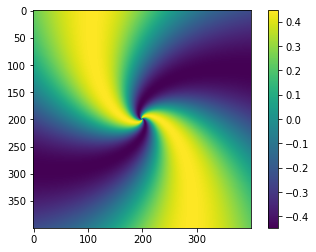

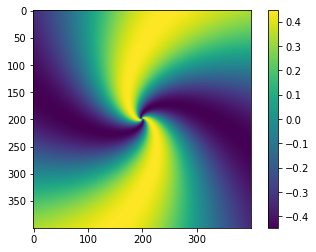

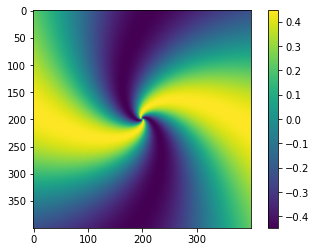

In [45]:
#ok... but this is a square and not a disk.... and also what are the units here?? I'm guessing this has to be compared
#with some already existing global surface density...

plt.imshow(spir0)
plt.colorbar()
plt.show()
plt.imshow(spir1)
plt.colorbar()
plt.show()
plt.imshow(spir2)
plt.colorbar()
plt.show()

In [46]:
for i in range(len(car)):
    for j in range(len(car)):
        if(g_r[i,j] > 100):
            spir2[i,j] = -np.inf

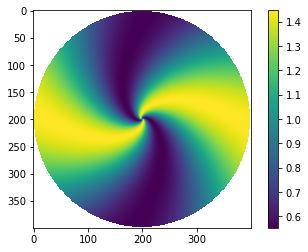

In [47]:
plt.imshow(spir2+1)
plt.colorbar()

In [48]:
unpert_sigma = giggle.sigma(p, 1, 100, md, g_r)

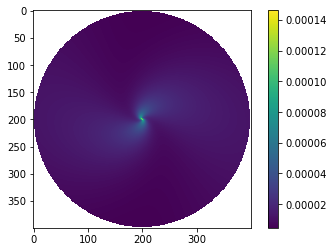

In [49]:
spiral_sigma = spir2*unpert_sigma + unpert_sigma

for i in range(len(car)):
    for j in range(len(car)):
        if(g_r[i,j] > 100):
            spiral_sigma[i,j] = -np.inf

plt.imshow(spiral_sigma)
plt.colorbar()

In [ ]:
 def set_structure(self):
        #tst=time.clock()
        '''Calculate the disk density and temperature structure given the specified parameters'''
        # Define the desired regular cylindrical (r,z) grid
        nac = 500#256             # - number of unique a rings
        #nrc = 256             # - numver of unique r points
        amin = self.Ain       # - minimum a [AU]
        amax = self.Aout      # - maximum a [AU]
        e = self.ecc          # - eccentricity
        nzc = int(2.5*nac)#nac*5           # - number of unique z points
        '''defining z-array: .1 AU to specified max value in AU. logarithmic. number specified by
        # of annuli'''
        zmin = .1*Disk.AU      # - minimum z [AU]
        nfc = self.nphi       # - number of unique f points
        af = np.logspace(np.log10(amin),np.log10(amax),nac)
        zf = np.logspace(np.log10(zmin),np.log10(self.zmax),nzc)

        #adding this to triple check z-dimension is doing what I think it is
        print("1d z-array " + str(zf))

        pf = np.linspace(0,2*np.pi,self.nphi) #f is with refrence to semi major axis
        ff = (pf - self.aop) % (2*np.pi) # phi values are offset by aop- refrence to sky
        rf = np.zeros((nac,nfc))
        for i in range(nac):
            for j in range(nfc):
                rf[i,j] = (af[i]*(1.-e*e))/(1.+e*np.cos(ff[j]))

        '''1d array of z-values as ones'''
        idz = np.ones(nzc)
        idf = np.ones(self.nphi)
        #rcf = np.outer(rf,idz)
        ida = np.ones(nac)
        ##zcf = np.outer(ida,zf)
        ##acf = af[:,np.newaxis]*np.ones(nzc)
        #order of dimensions: a, f, z
        '''meshgrid of z values above midplane'''
        pcf,acf,zcf = np.meshgrid(pf,af,zf)
        #zcf = (np.outer(ida,idf))[:,:,np.newaxis]*zf
        #pcf = (np.outer(ida,pf))[:,:,np.newaxis]*idz
        fcf = (pcf - self.aop) % (2*np.pi)
        #acf = (np.outer(af,idf))[:,:,np.newaxis]*idz
        
        '''should be 0 grid in shape of radius, phi, z above midplane'''
        rcf=rf[:,:,np.newaxis]*idz
        print(str(rcf.shape))
        #print("coords init {t}".format(t=time.clock()-tst))


        # Here introduce new z-grid (for now just leave old one in)

        # Interpolate dust temperature and density onto cylindrical grid
        ###### doesnt seem to be used anywhere ######


        # bundle the grid for helper functions
        ###### add angle to grid? ######
        '''nac, nfc, nzc are resolution (int) in each dimension. rcf is 0s grid in 3d. 
        amax is max a (AU), zcf is z meshgrid'''
        grid = {'nac':nac,'nfc':nfc,'nzc':nzc,'rcf':rcf,'amax':amax,'zcf':zcf}#'ff':ff,'af':af,
        self.grid=grid

        #print("grid {t}".format(t=time.clock()-tst))
        #define temperature structure
        # use Dartois (03) type II temperature structure
        ###### expanding to 3D should not affect this ######
        delta = 1.                # shape parameter
        rcf150=rcf/(150.*Disk.AU)
        rcf150q=rcf150**self.qq
        
        '''# zq0 = Zq, in AU, at 150 AU (????)'''
        '''zq should be 3d and scaled by 150 AU...???'''
        zq = self.zq0*Disk.AU*rcf150**1.3
        print("shape of zq " +str(zq.shape))
        print("zq " +str(zq))
    
        #zq = self.zq0*Disk.AU*(rcf/(150*Disk.AU))**1.1
        tmid = self.tmid0*rcf150q
        tatm = self.tatm0*rcf150q
        tempg = tatm + (tmid-tatm)*np.cos((np.pi/(2*zq))*zcf)**(2.*delta)

        '''ii is 3d boolean grid of z values above some critical value'''
        ii = zcf > zq
        tempg[ii] = tatm[ii]
        #Type I structure
#        tempg = tmid*np.exp(np.log(tatm/tmid)*zcf/zq)
        ###### this step is slow!!! ######

        # Calculate vertical density structure

        ## Circular:
        #Sc = self.McoG*(2.-self.pp)/(2*np.pi*self.Rc*self.Rc)
        #siggas = Sc*(rf/self.Rc)**(-1*self.pp)*np.exp(-1*(rf/self.Rc)**(2-self.pp))
        ## Elliptical:
        #asum = (np.power(af,-1*self.pp)).sum()
        rp1 = np.roll(rf,-1,axis=0)
        rm1 = np.roll(rf,1,axis=0)
        #*** Approximations used here ***#

        Sc = self.McoG*(2.-self.pp)/(self.Rc*self.Rc)
        siggas_r = Sc*(acf[:,:,0]/self.Rc)**(-1*self.pp)*np.exp(-1*(acf[:,:,0]/self.Rc)**(2-self.pp))

        dsdth = (acf[:,:,0]*(1-e*e)*np.sqrt(1+2*e*np.cos(fcf[:,:,0])+e*e))/(1+e*np.cos(fcf[:,:,0]))**2
        siggas = ((siggas_r*np.sqrt(1.-e*e))/(2*np.pi*acf[:,:,0]*np.sqrt(1+2*e*np.cos(fcf[:,:,0])+e*e)))*dsdth

        ## Add an extra ring
        if self.ring is not None:
            w = np.abs(rcf-self.Rring)<self.Wring/2.
            if w.sum()>0:
                tempg[w] = tempg[w]*(rcdf[w]/(150*Disk.AU))**(self.sig_enhance-self.qq)/((rcf[w].max())/(150.*Disk.AU))**(-self.qq+self.sig_enhance)


        self.calc_hydrostatic(tempg,siggas,grid)

        self.vel = np.sqrt(Disk.G*self.Mstar/(acf*(1-self.ecc**2.)))*(np.cos(self.aop+fcf)+self.ecc*self.cosaop)


        # Check for NANs
        ### nolonger use Omg ###
        #ii = np.isnan(Omg)
        #Omg[ii] = Omk[ii]
        ii = np.isnan(self.rho0)
        if ii.sum() > 0:
            self.rho0[ii] = 1e-60
            print('Beware: removed NaNs from density (#%s)' % ii.sum())
        ii = np.isnan(tempg)
        if ii.sum() > 0:
            tempg[ii] = 2.73
            print('Beware: removed NaNs from temperature (#%s)' % ii.sum())

        #print("nan chekc {t}".format(t=time.clock()-tst))
        # find photodissociation boundary layer from top
        zpht_up = np.zeros((nac,nfc))
        zpht_low = np.zeros((nac,nfc))
        sig_col = np.zeros((nac,nfc,nzc))
        #zice = np.zeros((nac,nfc))
        for ia in range(nac):
            for jf in range (nfc):
                psl = (Disk.Hnuctog/Disk.m0*self.rho0[ia,jf,:])[::-1]
                zsl = self.zmax - (zcf[ia,jf,:])[::-1]
                foo = (zsl-np.roll(zsl,1))*(psl+np.roll(psl,1))/2.
                foo[0] = 0
                nsl = foo.cumsum()
                sig_col[ia,jf,:] = nsl[::-1]*Disk.m0/Disk.Hnuctog
                pht = (np.abs(nsl) >= self.sigbound[0])
                if pht.sum() == 0:
                    zpht_up[ia,jf] = np.min(self.zmax-zsl)
                else:
                    zpht_up[ia,jf] = np.max(self.zmax-zsl[pht])
                #Height of lower column density boundary
                pht = (np.abs(nsl) >= self.sigbound[1])
                if pht.sum() == 0:
                    zpht_low[ia,jf] = np.min(self.zmax-zsl)
                else:
                    zpht_low[ia,jf] = np.max(self.zmax-zsl[pht])
                #used to be a seperate loop
                ###### only used for plotting
                #foo = (tempg[ia,jf,:] < Disk.Tco)
                #if foo.sum() > 0:
                #    zice[ia,jf] = np.max(zcf[ia,jf,foo])
                #else:
                #    zice[ia,jf] = zmin
        self.sig_col = sig_col
        #szpht = zpht
        #print("Zpht {t} seconds".format(t=(time.clock()-tst)))
        self.af = af
        #self.ff = ff
        #self.rf = rf
        self.pf = pf
        self.nac = nac
        self.zf = zf
        self.nzc = nzc
        self.tempg = tempg
        #self.Omg0 = Omg#velrot
        self.zpht_up = zpht_up
        self.zpht_low = zpht_low
        self.pcf = pcf  #only used for plotting can remove after testing
        self.rcf = rcf  #only used for plotting can remove after testing


/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:727: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(spir_rot), cmap='jet', vmin = -12.5, vmax = -8., origin='lower')
/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:727: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(spir_rot), cmap='jet', vmin = -12.5, vmax = -8., origin='lower')
/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:746: RuntimeWarning: invalid value encountered in add
  plt.imshow(-m1crot +m1krot, cmap='seismic', vmin = -0.8, vmax = 0.8, origin='lower')


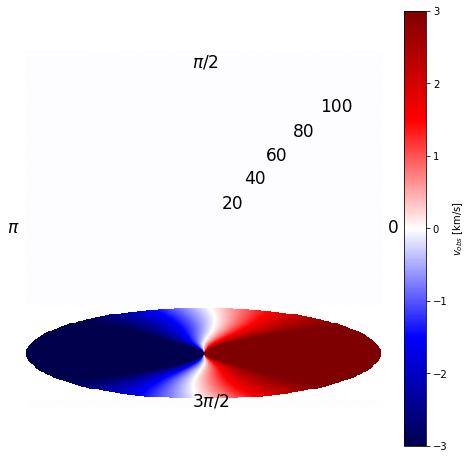

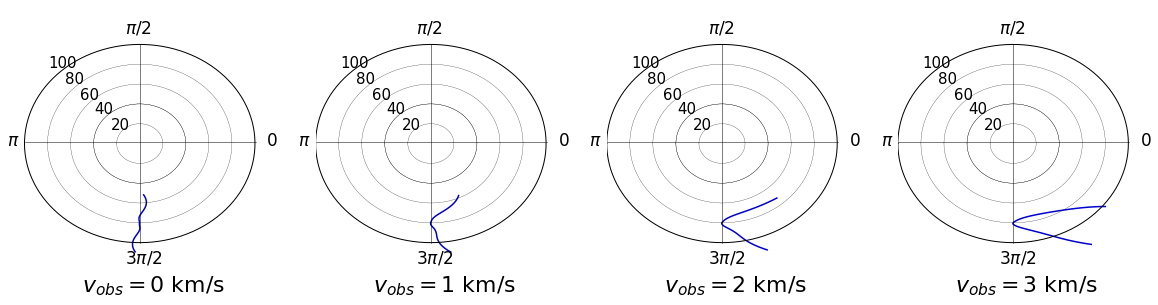

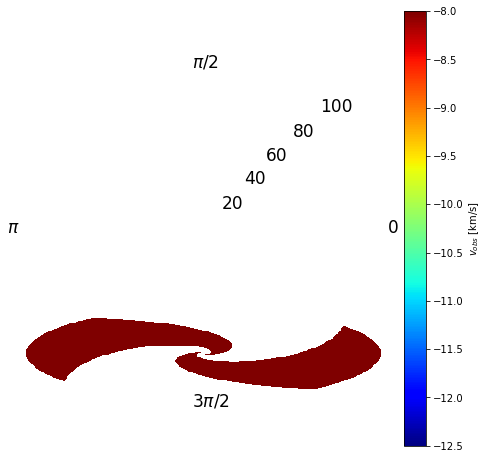

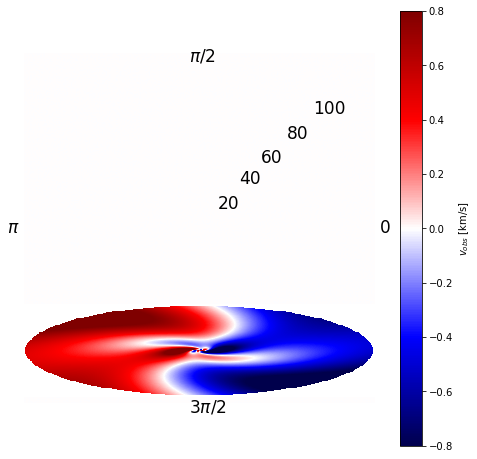

In [6]:
import disk_ecc_spiral as disk
x=disk.Disk()

1d z-array [1.49597871e+12 1.50491455e+12 1.51390376e+12 ... 2.51305201e+15
 2.52806307e+15 2.54316380e+15]
rf (1d) [[1.49597871e+14 1.49597871e+14 1.49597871e+14 ... 1.49597871e+14
  1.49597871e+14 1.49597871e+14]
 [1.50984870e+14 1.50984870e+14 1.50984870e+14 ... 1.50984870e+14
  1.50984870e+14 1.50984870e+14]
 [1.52384728e+14 1.52384728e+14 1.52384728e+14 ... 1.52384728e+14
  1.52384728e+14 1.52384728e+14]
 ...
 [1.46861980e+16 1.46861980e+16 1.46861980e+16 ... 1.46861980e+16
  1.46861980e+16 1.46861980e+16]
 [1.48223613e+16 1.48223613e+16 1.48223613e+16 ... 1.48223613e+16
  1.48223613e+16 1.48223613e+16]
 [1.49597871e+16 1.49597871e+16 1.49597871e+16 ... 1.49597871e+16
  1.49597871e+16 1.49597871e+16]]


UnboundLocalError: local variable 'ms' referenced before assignment

In [4]:
import giggle_functions as giggle
import numpy as np

1d z-array [1.49597871e+12 1.50491455e+12 1.51390376e+12 ... 2.51305201e+15
 2.52806307e+15 2.54316380e+15]
rf (1d) [[1.49597871e+14 1.49597871e+14 1.49597871e+14 ... 1.49597871e+14
  1.49597871e+14 1.49597871e+14]
 [1.50984870e+14 1.50984870e+14 1.50984870e+14 ... 1.50984870e+14
  1.50984870e+14 1.50984870e+14]
 [1.52384728e+14 1.52384728e+14 1.52384728e+14 ... 1.52384728e+14
  1.52384728e+14 1.52384728e+14]
 ...
 [1.46861980e+16 1.46861980e+16 1.46861980e+16 ... 1.46861980e+16
  1.46861980e+16 1.46861980e+16]
 [1.48223613e+16 1.48223613e+16 1.48223613e+16 ... 1.48223613e+16
  1.48223613e+16 1.48223613e+16]
 [1.49597871e+16 1.49597871e+16 1.49597871e+16 ... 1.49597871e+16
  1.49597871e+16 1.49597871e+16]]


/Volumes/disks/theo/49ceti_warpmodel/Spiral/giggle_functions.py:94: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( (G*ms/r) + veldisc(r,z,md,p,rin,rout))


self.vel_phi shape (500, 131, 1250)
self.vel_rad shape (500, 131, 1250)


/Volumes/disks/theo/49ceti_warpmodel/Spiral/disk_ecc_spiral.py:373: RuntimeWarning: divide by zero encountered in true_divide
  theta_crit = np.arctan((self.Aout*(1+self.ecc)+tdiskY)/(self.zmax-tdiskZ))


vel_rad shape (131, 180, 300)
vel_phi shape (131, 180, 300)


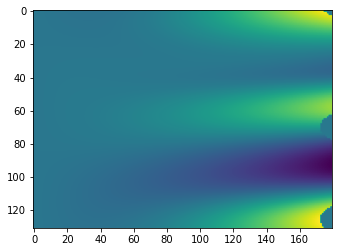

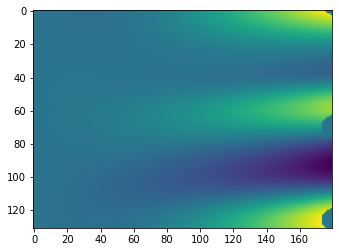

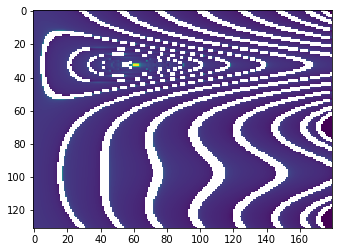

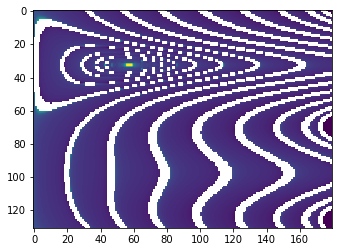

In [1]:
import disk_ecc_spiral as disk
x=disk.Disk()

In [2]:
%run raytrace.py
total_model(x)

With mirroring on, chanmin has been reset to put the line center in central channel
chanstep, nchans, chanmin: 0.320, 15.000, -2.240


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:359: RuntimeWarning: divide by zero encountered in true_divide
  tnl = gl*abund*disk.rhoG*np.exp(-(El/kB)/disk.T)/parZ


veloc shape ()


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:93: RuntimeWarning: divide by zero encountered in true_divide
  Signu = SignuF1*np.exp(-dV**2/disk.dBV**2)/disk.dBV*(1.-np.exp(-(BBF2*nu)/disk.T))   # - absorbing cross section
/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:93: RuntimeWarning: invalid value encountered in true_divide
  Signu = SignuF1*np.exp(-dV**2/disk.dBV**2)/disk.dBV*(1.-np.exp(-(BBF2*nu)/disk.T))   # - absorbing cross section


disk.vel shape (131, 180, 300)


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:105: RuntimeWarning: divide by zero encountered in true_divide
  Snu = BBF1*nu**3/(np.exp((BBF2*nu)/disk.T)-1.) # - source function
/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:105: RuntimeWarning: overflow encountered in exp
  Snu = BBF1*nu**3/(np.exp((BBF2*nu)/disk.T)-1.) # - source function


veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)


In [1]:
import disk_ecc as kevindisk

In [2]:
y=kevindisk.Disk()

1d z-array [1.49597871e+12 1.50491455e+12 1.51390376e+12 ... 2.51305201e+15
 2.52806307e+15 2.54316380e+15]
(500, 131, 1250)


/Volumes/disks/theo/49ceti_warpmodel/Spiral/disk_ecc.py:510: RuntimeWarning: divide by zero encountered in true_divide
  theta_crit = np.arctan((self.Aout*(1+self.ecc)+tdiskY)/(self.zmax-tdiskZ))


In [3]:
%run raytrace.py
total_model(y)

With mirroring on, chanmin has been reset to put the line center in central channel
chanstep, nchans, chanmin: 0.320, 15.000, -2.240


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:359: RuntimeWarning: divide by zero encountered in true_divide
  tnl = gl*abund*disk.rhoG*np.exp(-(El/kB)/disk.T)/parZ


veloc shape ()


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:93: RuntimeWarning: divide by zero encountered in true_divide
  Signu = SignuF1*np.exp(-dV**2/disk.dBV**2)/disk.dBV*(1.-np.exp(-(BBF2*nu)/disk.T))   # - absorbing cross section
/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:93: RuntimeWarning: invalid value encountered in true_divide
  Signu = SignuF1*np.exp(-dV**2/disk.dBV**2)/disk.dBV*(1.-np.exp(-(BBF2*nu)/disk.T))   # - absorbing cross section


disk.vel shape (131, 180, 300)


/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:105: RuntimeWarning: divide by zero encountered in true_divide
  Snu = BBF1*nu**3/(np.exp((BBF2*nu)/disk.T)-1.) # - source function
/Volumes/disks/theo/49ceti_warpmodel/Spiral/raytrace.py:105: RuntimeWarning: overflow encountered in exp
  Snu = BBF1*nu**3/(np.exp((BBF2*nu)/disk.T)-1.) # - source function


veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)
veloc shape ()
disk.vel shape (131, 180, 300)


In [11]:


ms = 1 #star mass
md = 0.35 #disc mass
p = -.5 #surface density
ap = 60*np.pi/180 #pitch angle
m = 2 #azimuthal wavenumber
beta = 5 #cool
incl = np.pi/2.1 #inclination of the disc towards the line of sight
pos = 90 # rotation of spiral (degrees), starting north, cw

vel_phi = giggle.uph(rcf, pcf, ms, md, p, m, 1, beta, 1, 10, ap, 0)[:,:,np.newaxis]*idz
print("self.vel_phi shape " + str(vel_phi.shape))
vel_rad = giggle.ur(rcf, pcf, ms, md, p, m, 1, beta, 1, 10, ap, 0) 
print("self.vel_rad shape " + str(vel_rad.shape))

self.vel_phi shape (500, 180, 1250)


KeyboardInterrupt: 

In [10]:
rcf.shape

(500, 180, 1250)

In [ ]:
#disk.Disk.set_structure()

TypeError: set_structure() missing 1 required positional argument: 'self'

In [9]:
#understanding structure of perturbed_sigma and how to use it
#Parameters
ms = 1 #star mass
md = 0.35 #disc mass
p = -.5 #surface density
ap = 60*np.pi/180 #pitch angle
m = 2 #azimuthal wavenumber
beta = 5 #cool
incl = np.pi/2.1 #inclination of the disc towards the line of sight
pos = 90 # rotation of spiral (degrees), starting north, cw

def ura(ms, md, p, m, chi, beta, rin, rout, r):
    
    '''Module of the radial velocity perturbation [km/s]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    r = radius [au]'''
    
    return 2 * m * chi * beta**(-1/2) * giggle.q(ms, md, p, rin, rout, r)**2 * giggle.omega(ms,r) * r

In [14]:
ura_test = ura(ms, md, p, 2, 1, beta, 1, 100, rcf)

In [15]:
ura_test.shape

(500, 180, 1250)

In [16]:
ura_test

array([[[6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06],
        [6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06],
        [6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06],
        ...,
        [6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06],
        [6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06],
        [6.52685592e-06, 6.52685592e-06, 6.52685592e-06, ...,
         6.52685592e-06, 6.52685592e-06, 6.52685592e-06]],

       [[6.67919412e-06, 6.67919412e-06, 6.67919412e-06, ...,
         6.67919412e-06, 6.67919412e-06, 6.67919412e-06],
        [6.67919412e-06, 6.67919412e-06, 6.67919412e-06, ...,
         6.67919412e-06, 6.67919412e-06, 6.67919412e-06],
        [6.67919412e-06, 

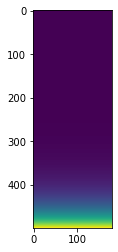

In [18]:
plt.imshow(ura_test[:,:,50])

In [7]:

nac = 500#256             # - number of unique a rings
#nrc = 256             # - numver of unique r points
amin = 1       # - minimum a [AU]
amax = 100      # - maximum a [AU]
e = 0          # - eccentricity
nzc = int(2.5*nac)#nac*5           # - number of unique z points
'''defining z-array: .1 AU to specified max value in AU. logarithmic. number specified by
# of annuli'''
zmin = .1      # - minimum z [AU]
nfc = 180      # - number of unique f points
af = np.logspace(np.log10(amin),np.log10(amax),nac)
zf = np.logspace(np.log10(zmin),np.log10(10),nzc)

#adding this to triple check z-dimension is doing what I think it is
#print("1d z-array " + str(zf))

pf = np.linspace(0,2*np.pi,180) #f is with refrence to semi major axis
ff = (pf - 0) % (2*np.pi) # phi values are offset by aop- refrence to sky
rf = np.zeros((nac,nfc))
for i in range(nac):
    for j in range(nfc):
        rf[i,j] = (af[i]*(1.-e*e))/(1.+e*np.cos(ff[j]))

'''1d array of z-values as ones'''
idz = np.ones(nzc)
idf = np.ones(180)
#rcf = np.outer(rf,idz)
ida = np.ones(nac)
##zcf = np.outer(ida,zf)
##acf = af[:,np.newaxis]*np.ones(nzc)
#order of dimensions: a, f, z
'''meshgrid of z values above midplane'''
pcf,acf,zcf = np.meshgrid(pf,af,zf)
#zcf = (np.outer(ida,idf))[:,:,np.newaxis]*zf
#pcf = (np.outer(ida,pf))[:,:,np.newaxis]*idz
fcf = (pcf - 0) % (2*np.pi)
#acf = (np.outer(af,idf))[:,:,np.newaxis]*idz

'''should be 0 grid in shape of radius, phi, z above midplane'''
rcf=rf[:,:,np.newaxis]*idz

In [7]:
rcf.shape

(500, 180, 1250)

TypeError: ura() missing 2 required positional arguments: 'rout' and 'r'

In [9]:
def urC(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off):
    
    '''2D radial velocity perturbation [km/s] in polar coordinates
    gx = x grid [au]
    gy = y grid [au] 
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    return - ura(ms, md, p, m, chi, beta, rin, rout, grid_radius)  * np.sin(
        m * grid_angle + m/np.tan(alpha) * -np.log(grid_radius) + off)



def uphC(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off):
    
    '''2D azimuthal velocity perturbation [km/s] in polar coordinates
    gx = x grid [au]
    gy = y grid [au] 
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    # x = np.linspace(np.min(grid_radius),np.max(grid_radius),grid_radius.shape[0]/2)
    #phase = m / np.tan(alpha)  * np.log(x)
    #an = np.linspace(-np.pi,np.pi,grid_radius.shape[1])
    #bs = basicspeed(x, 0.001, md, p, rin, rout, ms)
    #vec = np.zeros([grid_radius.shape[0],grid_radius.shape[1]])
    #vp1 = upha(ms, md, p, m, chi, beta, rin, rout, rin)
    #for i in range(grid_radius.shape[1]):
    #   vec[:,i] = bs[:] - vp1* x**(3/2 + p) /rin * np.sin(m*an[i] + phase[:] + off)
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    phase = m / np.tan(alpha) * -np.log(grid_radius)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    
    radii = np.linspace(np.min(grid_radius), np.max(grid_radius), 1000)
    rc = basicspeed(radii, 1e-3, md, p, rin, rout, ms)
    #vec = - upha(ms, md, p, m, chi, beta, rin, rout, grid_radius) * np.sin(m*grid_angle + phase + off)  + rc[
     #   ((grid_radius - np.min(grid_radius))/(radii[1] - radii[0])).astype(int)] 
    vec = np.sqrt( (G*ms/grid_radius)) * beta**(-0.5) / 2 * (md/ms) * np.sin(m*grid_angle + phase + off) + rc[
        ((grid_radius - np.min(grid_radius))/(radii[1] - radii[0])).astype(int)] 
    return vec



def momentoneC(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, incl, off):
    
    '''Moment one map / projected velocity field towards the line of sight [km/s]
    gx = x grid [au]
    gy = y grid [au] 
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]
    incl = inclination angle [rad]
    NB: The moment one map is given in polar coordinates, the disk is face on and the observer is rotated by an angle incl'''
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    
    M1 = uphC(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off) * np.cos(
        grid_angle) * np.sin(incl) + urC(gx, gy, ms, md, p, m, chi, beta,
        rin, rout, alpha, off) * np.sin(grid_angle) * np.sin(incl)
    for i in range(M1.shape[0]):
        for j in range(M1.shape[0]):
            if(grid_radius[i,j] > rout):
                M1[i,j] = -np.inf
    return M1

def uraB(ms, md, p, m, chi, beta, rin, rout, r, n):
    
    '''Module of the radial velocity perturbation [km/s]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    r = radius [au]'''
    
    return 8 * m * chi * beta**(-1/2) * q(ms, md, p, rin, rout, r)**2 * omega(ms,r) * r * (r/rin)**(-n/2)



def uphaB(ms, md, p, m, chi, beta, rin, rout, r, n):
    
    '''Module of the azimuthal velocity perturbation [km/s]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    r = radius [au]'''
    
    return - (m * chi * beta**(-1/2))  * q(ms, md, p, rin, rout, r) * omega(ms,r) * r * (r/rin)**(-n/2)

def urCeta(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off, n):
    
    '''2D radial velocity perturbation [km/s] in polar coordinates
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    return - uraB(ms, md, p, m, chi, beta, rin, rout, grid_radius, n)  * np.sin(
        m * grid_angle + m/np.tan(alpha) * np.log(grid_radius) + off)



def uphCeta(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off, n):
    
    '''2D azimuthal velocity perturbation [km/s] in polar coordinates
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]'''
    
    # x = np.linspace(np.min(grid_radius),np.max(grid_radius),grid_radius.shape[0]/2)
    #phase = m / np.tan(alpha)  * np.log(x)
    #an = np.linspace(-np.pi,np.pi,grid_radius.shape[1])
    #bs = basicspeed(x, 0.001, md, p, rin, rout, ms)
    #vec = np.zeros([grid_radius.shape[0],grid_radius.shape[1]])
    #vp1 = upha(ms, md, p, m, chi, beta, rin, rout, rin)
    #for i in range(grid_radius.shape[1]):
    #   vec[:,i] = bs[:] - vp1* x**(3/2 + p) /rin * np.sin(m*an[i] + phase[:] + off)
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    
    radii = np.linspace(np.min(grid_radius), np.max(grid_radius), 1000)
    rc = basicspeed(radii, 1e-3, md, p, rin, rout, ms)
    vec = - uphaB(ms, md, p, m, chi, beta, rin, rout, grid_radius, n) + rc[
        ((grid_radius - np.min(grid_radius))/(radii[1] - radii[0])).astype(int)] 
    return vec



def momentoneCeta(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, incl, off, n):
    
    '''Moment one map / projected velocity field towards the line of sight [km/s]
    gx = x grid [au]
    gy = y grid [au] 
    ms = mass of the central object [msun]
    md = mass of the disc [msun]
    p = power law index of the density profile. \Sigma \propto r^(p)
    m = number of the spiral arms
    chi = heating factors (=1)
    beta = cooling factor
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    alpha = pitch angle of the spiral [rad]
    incl = inclination angle [rad]
    NB: The moment one map is given in polar coordinates, the disk is face on and the observer is rotated by an angle incl'''
    
    grid_radius = np.sqrt(gx**2 + gy**2)
    car = np.linspace(-rout,rout,gx.shape[0])
    grid_angle = np.zeros([len(car),len(car)])
    for i in range(len(car)):
        for j in range(len(car)):
            grid_angle[i,j] = math.atan2(car[i], car[j])
    
    M1 = uphCeta(gx, gy, ms, md, p, m, chi, beta, rin, rout, alpha, off, n) * np.cos(
        grid_angle) * np.sin(incl) + urCeta(gx, gy, ms, md, p, m, chi, beta,
        rin, rout, alpha, off, n) * np.sin(grid_angle) * np.sin(incl)
    for i in range(M1.shape[0]):
        for j in range(M1.shape[0]):
            if(grid_radius[i,j] > rout):
                M1[i,j] = -np.inf
    return M1
